In [2]:
# set the working directory to be the root of the package
# so that the imports work below
import sys
sys.path.append("..")

In [3]:
import numpy as np
import pandas as pd
import sklearn as skl
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
import models.data_util

In [4]:
data_file = "../data/full.pkl"  # set this accordingly

# Load the lat/long for each company
x, y = models.data_util.load_raw_data(data_file, cols=['lat', 'long'])

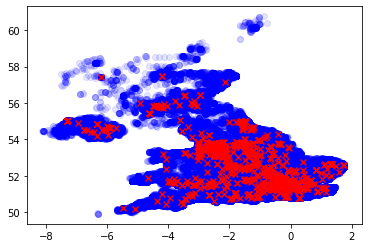

In [5]:
failedcomps = np.nonzero(y == 1)
notfailedcomps = np.nonzero(y == 0)

plt.scatter(x[notfailedcomps].T[1], x[notfailedcomps].T[0],
            marker='o', alpha=0.1, color='blue')
plt.scatter(x[failedcomps].T[1], x[failedcomps].T[0],
            marker='x', alpha=1.0, color='red')
plt.show()

In [6]:
# Now use Principal Component Analysis with Radial Basis Function kernel to decompose the lat/long
# representation into something more useful.

# Due to memory constraints, we have to fit this on a smaller dataset:
xsmall = x[np.random.choice(np.array(range(0, len(x))), size=2000)]

# Create the kernel PCA object (project into 2 dimensions)
transformer = KernelPCA(n_components=2, kernel='rbf')

# Fit transformation:
transformer.fit_transform(xsmall)

(5196, 2)


In [9]:
N = 10000

# Transforming the whole dataset requires like 9Gb RAM, so
# only transform a subset of that:
xtransformed = transformer.transform(np.concatenate((
    x[notfailedcomps][:N],
    x[failedcomps]
)))

# Apply transformation to whole initial dataset:
print(xtransformed.shape)

(11196, 2)


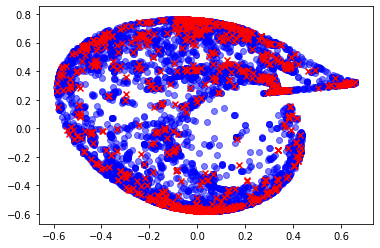

In [10]:
plt.scatter(xtransformed[:N].T[1], xtransformed[:N].T[0],
            marker='o', alpha=0.5, color='blue')
plt.scatter(xtransformed[N:].T[1], xtransformed[N:].T[0],
            marker='x', alpha=1.0, color='red')
plt.show()